## Import `fptools`
The first thing to do is import `fptools` as well as some other utilities.

- `fptools.io` contains data loading functionality via `load_data()`, and common data classes such as `Session`, `SessionCollection`, `Signal`, etc.
- `fptools.io.test` contains functions to download a test data set.
- `fptools.preprocess.pipelines` contains some prebuilt preprocessing pipelines.
- `fptools.measure` contains several methods for measuring different aspects of the data. The submodule `signal_collector` contains methods to collect signals around epocs.
- `fptools.viz` contains several methods for visualizing your data.

In [1]:
import os

from fptools.io import load_data, Session, SessionCollection
from fptools.preprocess.pipelines import LowpassDFFPipeline
from fptools.io.test import download_test_data, list_datasets
from fptools.measure.signal_collector import collect_signals, collect_signals_2event
from fptools.viz.signal import sig_catplot

## Let's download some test/demo data
The following code will download a demo dataset to your local computer, if it does not already exist. The variable `test_data_path` will contain the path to the root of the test dataset folder. If the parameter `dest` is `None`, the data will be downloaded to a location within the current user's home directory.

Use the function `list_datasets()` to list the names of the available datasets within the demo data.

In [2]:
test_data_path = download_test_data()
list_datasets()

Test data appears to already be in place at "C:\Users\thackray\fptools_test_data".


['MA-PR4-4Day', 'TDT-DLS-GRABDA2m-Male-PR4-2Day']

## Time to load the data

The `load_data()` function from `fptools.io` is your main gateway to loading data in a variety of formats. Shown below is an example of loading data from a TDT tank. See the comments below for a brief explanation of the parameters for `load_data()`.

The `load_data()` function will return to you a `SessionCollection`, which is really a `list` with extra functionality built-in. This means you can largely use it any way you would use a normal python list.

For this example, we will load fiber photometry data collected using a TDT system. Data was collected from the DLS using the GRABDA2m sensor in male mice (~2mo) in a progressive ratio task across two days. For brevity, only the first 10 minutes of each session is included in this dataset.

In [3]:
# `tank_path` is the path to the dataset we want to load
tank_path = os.path.join(test_data_path, "TDT-DLS-GRABDA2m-Male-PR4-2Day")

rename_map = {
    "signals": {
        '_465A': 'Dopamine',
        '_415A': 'Isosbestic',
    },
    "epocs": {
        "RNP_": "RNP",
    }
}

sessions = load_data(tank_path,

                     # path to a manifest file for additional metadata to inject into sessions
                     # manifest index tells the system how to key the manifest and assoicate to data
                     # for TDT data, Sessions are named as the blockname.
                     manifest_path=os.path.join(tank_path, 'manifest.xlsx'),
                     manifest_index='blockname',

                     # use multiple worker processes to load data in parallel
                     max_workers=4,

                     # The locator tells the system what type of data we are looking for.
                     # more complex functionality is available, but most folks could use the string "tdt" for TDT tank files
                     # or the string "ma" for med-associates style files.
                     locator="tdt",

                     # a function to run any preprocessing needed (see library of pre-made pipelines in `fptools.preprocess.pipelines`)
                     preprocess=LowpassDFFPipeline(
                         signals=['_465A', '_415A'],
                         rename_map=rename_map,
                         trim_begin="auto",
                         downsample=10,
                         plot=True,
                         plot_dir=os.path.join(tank_path, 'cache_lowpass_dff'),
                     ),

                     # control if we want to cache files, and where that cache should live
                     cache=True,
                     cache_dir=os.path.join(tank_path, 'cache_lowpass_dff'),
                     )

  0%|          | 0/16 [00:00<?, ?it/s]

## Get an overview of `SessionCollection` contents

The `SessionCollection.describe()` method will print you a string summary of the datasets contained within the collection. Next to each dataset, the number of sessions containing a dataset with that name is provided within the parenthesis.

In [4]:
sessions.describe()

Number of sessions: 16

Signals present in data with counts:
(16) "Dopamine"
(16) "Dopamine_lowpass"
(16) "Isosbestic"
(16) "Isosbestic_lowpass"

Epocs present in data with counts:
(16) "Cam1"
(16) "Nose"
(16) "P1SC"
(16) "RMG_"
(16) "RNP"
(16) "Tick"
(16) "URM_"
(16) "UnNP"

Scalars present in data with counts:
(16) "Fi1i"




## Get an overview of `Session` contents.

Similar to `SessionCollection.describe()`, there is also a `Session.describe()`. The information here is a bit more detailed than at the collection level. Where possibe, we provide summary statistics for each dataset.

In [5]:
sessions[0].describe()

Session with name "EN140_PRD2-240814-140637"

Metadata:
    blockname: EN140_PRD2-240814-140637
    cable in?: True
    cube: TDT1
    duration: 0:59:59.194253
    exclude: False
    genotype: HET
    hemisphere: L
    mouseID: EN140
    notes: nan
    paradigm: PR4
    paradigm_day: 2
    sensor: GRABDA2M
    sex: M
    snip_channel: 0
    start_date: 2024-08-14 14:06:42.999999
    stop_date: 2024-08-14 15:06:42.194252
    stream_channel: 0
    tankpath: C:\Users\thackray\fptools_test_data\TDT-DLS-GRABDA2m-Male-PR4-2Day
    utc_start_time: 14:06:42
    utc_stop_time: 15:06:42

Epocs:
    Cam1:
        num_events = (11999,)
        avg_rate = 0:00:00.048824
        earliest = 0:00:00.086016
        latest = 0:09:59.984701
    Nose:
        num_events = (242,)
        avg_rate = 0:00:00.209715
        earliest = 0:00:00.644383
        latest = 0:09:28.401265
    P1SC:
        num_events = (23,)
        avg_rate = 0:00:03.015475
        earliest = 0:00:00.666829
        latest = 0:09:30.

## Fetch metadata across sessions as a DataFrame

Use the `SessionCollection.metadata` property to retrieve a `pandas.DataFrame` containing metadata across sessions. *Note*: changing values in this dataframe will not have any effect on the underlying data. Instead, make these changes on the underlying `Session.metadata` property.

In [6]:
sessions.metadata

,blockname,cable in?,cube,duration,exclude,genotype,hemisphere,mouseID,notes,paradigm,paradigm_day,sensor,sex,snip_channel,start_date,stop_date,stream_channel,tankpath,utc_start_time,utc_stop_time
0,EN140_PRD2-240814-140637,True,TDT1,0 days 00:59:59.194253,False,HET,L,EN140,NaN,PR4,2,GRABDA2M,M,0,2024-08-14 14:06:42.999999,2024-08-14 15:06:42.194252,0,C:\Users\thackray\fptools_test_data\TDT-DLS-GR...,14:06:42,15:06:42
1,EN157_PRD1-240814-125543,True,TDT1,0 days 00:59:59.199823,False,WTY,R,EN157,NaN,PR4,1,GRABDA2M,M,0,2024-08-14 12:55:48.999999,2024-08-14 13:55:48.199822,0,C:\Users\thackray\fptools_test_data\TDT-DLS-GR...,12:55:48,13:55:48
2,EN140_PRD1-240813-133324,True,TDT1,0 days 00:59:59.101191,False,HET,L,EN140,NaN,PR4,1,GRABDA2M,M,0,2024-08-13 13:33:28.999999,2024-08-13 14:33:28.101190,0,C:\Users\thackray\fptools_test_data\TDT-DLS-GR...,13:33:28,14:33:28
3,EN157_PRD2-240815-122504,True,TDT1,0 days 00:59:59.098734,False,WTY,R,EN157,NaN,PR4,2,GRABDA2M,M,0,2024-08-15 12:25:08.999999,2024-08-15 13:25:08.098733,0,C:\Users\thackray\fptools_test_data\TDT-DLS-GR...,12:25:08,13:25:08
4,EN165_PRD1-240818-150154,True,TDT2,0 days 00:59:59.078418,False,WTY,R,EN165,NaN,PR4,1,GRABDA2M,M,0,2024-08-18 15:01:59.999999,2024-08-18 16:01:59.078417,0,C:\Users\thackray\fptools_test_data\TDT-DLS-GR...,15:01:59,16:01:59
5,EN165_PRD2-240819-144305,True,TDT2,0 days 00:59:59.081367,False,WTY,R,EN165,NaN,PR4,2,GRABDA2M,M,0,2024-08-19 14:43:10.999999,2024-08-19 15:43:10.081366,0,C:\Users\thackray\fptools_test_data\TDT-DLS-GR...,14:43:10,15:43:10
6,EN171_PRD1-240815-144154,True,TDT2,0 days 00:59:59.085299,False,HET,L,EN171,NaN,PR4,1,GRABDA2M,M,0,2024-08-15 14:41:59.999999,2024-08-15 15:41:59.085298,0,C:\Users\thackray\fptools_test_data\TDT-DLS-GR...,14:41:59,15:41:59
7,EN171_PRD2-240816-125119,True,TDT2,0 days 00:59:59.078090,False,HET,L,EN171,NaN,PR4,2,GRABDA2M,M,0,2024-08-16 12:51:24.999999,2024-08-16 13:51:24.078089,0,C:\Users\thackray\fptools_test_data\TDT-DLS-GR...,12:51:24,13:51:24
8,EN172_PRD1-240814-104140,True,TDT2,0 days 00:59:59.094146,False,WTY,R,EN172,NaN,PR4,1,GRABDA2M,M,0,2024-08-14 10:41:45.999999,2024-08-14 11:41:45.094145,0,C:\Users\thackray\fptools_test_data\TDT-DLS-GR...,10:41:45,11:41:45
9,EN172_PRD2-240815-111039,True,TDT2,0 days 00:59:59.231936,False,WTY,R,EN172,NaN,PR4,2,GRABDA2M,M,0,2024-08-15 11:10:44.999999,2024-08-15 12:10:44.231935,0,C:\Users\thackray\fptools_test_data\TDT-DLS-GR...,11:10:44,12:10:44


## Renaming
Renaming is useful because these name are often used by plotting functions for legends, labels, etc. So renaming your data appropriately will reflect better in plots. It may also be easier to reason about your code since the names are often given as parameters to several functions.

- Rename epocs across sessions using the `rename_epoc()` method
- Rename signals across sessions using the `rename_signal()` method
- Rename scalars across sessions using the `rename_scalar()` method


In [7]:
# Here, we will rename a few epocs from their TDT names, which contain underscores,
# to a more refined version of the epoc name.
# sessions.rename_epoc('RNP_', 'RNP') # this one we renamed during preprocessing while loading data
sessions.rename_epoc('RMG_', 'RMG')
sessions.rename_epoc('URM_', 'URM')

## Filtering
Filter session collections using the `filter()` method. This takes a predicate (i.e. a callable accepting a Session and returning a boolean to indicate inclusion or exclusion).

In [8]:
# here we define a suitable predicate function
def is_day1(session: Session) -> bool:
    return session.metadata['paradigm_day'] == 1

# and then apply the predicate
day1_sessions = sessions.filter(is_day1)
print(f"# day 1 sessions: {len(day1_sessions)}")


# another way to specify the predicate is via a lambda function
day2_sessions = sessions.filter(lambda session: session.metadata['paradigm_day'] == 2)
print(f"# day 2 sessions: {len(day2_sessions)}")


# day 1 sessions: 8
# day 2 sessions: 8


## Apply a function across all sessions
Often you may want to apply an arbitrary function across Sessions. For this, use the `apply()` method on `SessionCollection`.

In [9]:
# define a function that accepts a `Session` parameter, and returns `None`
# within, do what you please...
def add_rewards_earned_to_metadata(session: Session) -> None:
    '''Count the number of rewards earned and add this data to the session metadata

    Args:
        session: the session to interrogate and decorate with additional metadata
    '''
    rewards_earned = session.epocs['RNP'].shape[0]
    session.metadata['rewards_earned'] = rewards_earned
    print(f'Animal {session.metadata["mouseID"]} earned {rewards_earned} rewards')

# now apply the function
sessions.apply(add_rewards_earned_to_metadata)

# we can check for a side effect of this function,
# in this case this would be a new column in metadata
print("metadata columns: ", sessions.metadata_keys)

Animal EN140 earned 8 rewards
Animal EN157 earned 6 rewards
Animal EN140 earned 7 rewards
Animal EN157 earned 5 rewards
Animal EN165 earned 6 rewards
Animal EN165 earned 7 rewards
Animal EN171 earned 5 rewards
Animal EN171 earned 6 rewards
Animal EN172 earned 5 rewards
Animal EN172 earned 8 rewards
Animal EN175 earned 6 rewards
Animal EN175 earned 7 rewards
Animal EN181 earned 5 rewards
Animal EN181 earned 8 rewards
Animal EN182 earned 7 rewards
Animal EN182 earned 6 rewards
metadata columns:  ['notes', 'utc_start_time', 'mouseID', 'blockname', 'cable in?', 'paradigm_day', 'sensor', 'snip_channel', 'sex', 'genotype', 'start_date', 'stop_date', 'tankpath', 'cube', 'hemisphere', 'exclude', 'paradigm', 'utc_stop_time', 'duration', 'rewards_earned', 'stream_channel']


## Plotting Signals and Epocs

Often, we want to plot the average signal around some recurring event.

First, we must collect the signal around the event of interest. Use the `collect_signals()` method to perform this operation, which returns a new `Signal` object. You must add the new `Signal` to the session. By default the name of the produced signal will have the form `<input-signal-name>@<input-epoc-name>`, but you may always override this using the `out_name` keyword argument.

Another variant of signal collection exists for when you want to collect the signal around two different events, which might not have a constant inter-event interval. For this situation, you can use the `collect_signals_2event()` method. It will "stretch" or "shrink" the inter-event interval and resample for each trial to the duration given by the `inter` arg, thus allowing the two events to be aligned regardless of the true inter-event interval.

In [10]:
# for each session, collect the signals around the epoc(s) of interest, and then add the new `Signal` to the session.
for session in sessions:
    # collect the signals around the RNP epoc, which signals a rewarded nose poke was performed by the animal
    session.add_signal(collect_signals(session, 'RNP', 'Dopamine', start=-3, stop=5))
    session.add_signal(collect_signals(session, 'RNP', 'Isosbestic', start=-3, stop=5))

    # collect the signals around the RNP and RMG epocs, which signals first a reward was delivered to the animal
    # and then the animal successfully retrieved the reward from the reward port
    session.add_signal(collect_signals_2event(session, 'RNP', 'RMG', 'Dopamine', pre=5, post=5, inter=5))
    session.add_signal(collect_signals_2event(session, 'RNP', 'RMG', 'Isosbestic', pre=5, post=5, inter=5))

# lets look at what the first session looks like now
# notice the new signals we added:
# - `Dopamine@RNP`
# - `Dopamine@RNP>RMG`
# - `Isosbestic@RNP`
# - `Isosbestic@RNP>RMG`
sessions[0].describe()

Session with name "EN140_PRD2-240814-140637"

Metadata:
    blockname: EN140_PRD2-240814-140637
    cable in?: True
    cube: TDT1
    duration: 0:59:59.194253
    exclude: False
    genotype: HET
    hemisphere: L
    mouseID: EN140
    notes: nan
    paradigm: PR4
    paradigm_day: 2
    sensor: GRABDA2M
    sex: M
    snip_channel: 0
    start_date: 2024-08-14 14:06:42.999999
    stop_date: 2024-08-14 15:06:42.194252
    stream_channel: 0
    tankpath: C:\Users\thackray\fptools_test_data\TDT-DLS-GRABDA2m-Male-PR4-2Day
    utc_start_time: 14:06:42
    utc_stop_time: 15:06:42
    rewards_earned: 8

Epocs:
    Cam1:
        num_events = (11999,)
        avg_rate = 0:00:00.048824
        earliest = 0:00:00.086016
        latest = 0:09:59.984701
    Nose:
        num_events = (242,)
        avg_rate = 0:00:00.209715
        earliest = 0:00:00.644383
        latest = 0:09:28.401265
    P1SC:
        num_events = (23,)
        avg_rate = 0:00:03.015475
        earliest = 0:00:00.666829
   

## Plotting the collected signals

The `sig_catplot()` function is a convenient way to plot the collected signals, and it accepts a `SessionCollection` as input. In many ways the interface for this function is similar to the `seaborn.catplot()` method.

Below we will plot the dopamine signal at RNP epocs, splitting different days across columns, and coloring by the animal's genotype.

(<Figure size 1800x600 with 2 Axes>,
 array([[<Axes: title={'center': 'Dopamine@RNP>RMG at paradigm_day = 1'}, xlabel='Time, Relative to Event (s)', ylabel='Dopamine@RNP>RMG#mean (ΔF/F)'>,
         <Axes: title={'center': 'Dopamine@RNP>RMG at paradigm_day = 2'}, xlabel='Time, Relative to Event (s)', ylabel='Dopamine@RNP>RMG#mean (ΔF/F)'>]],
       dtype=object))

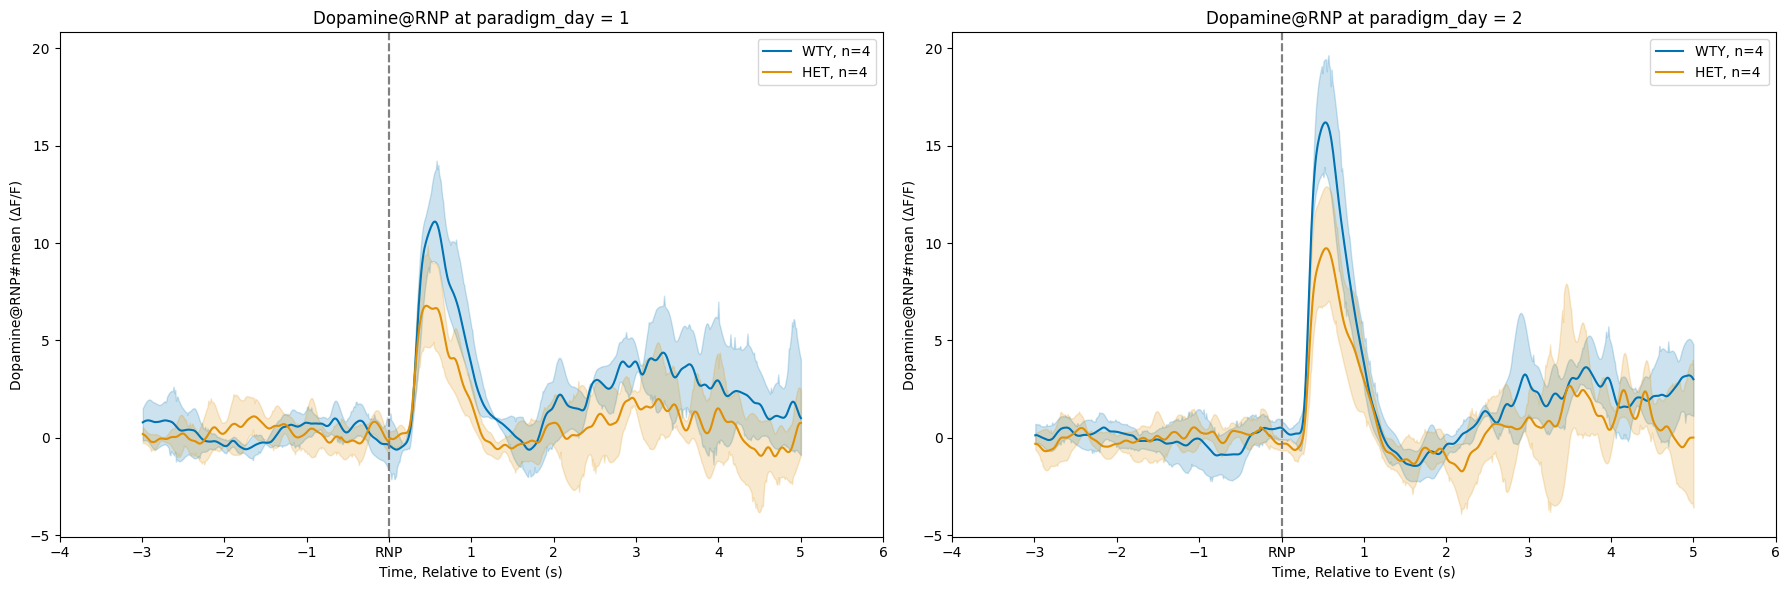

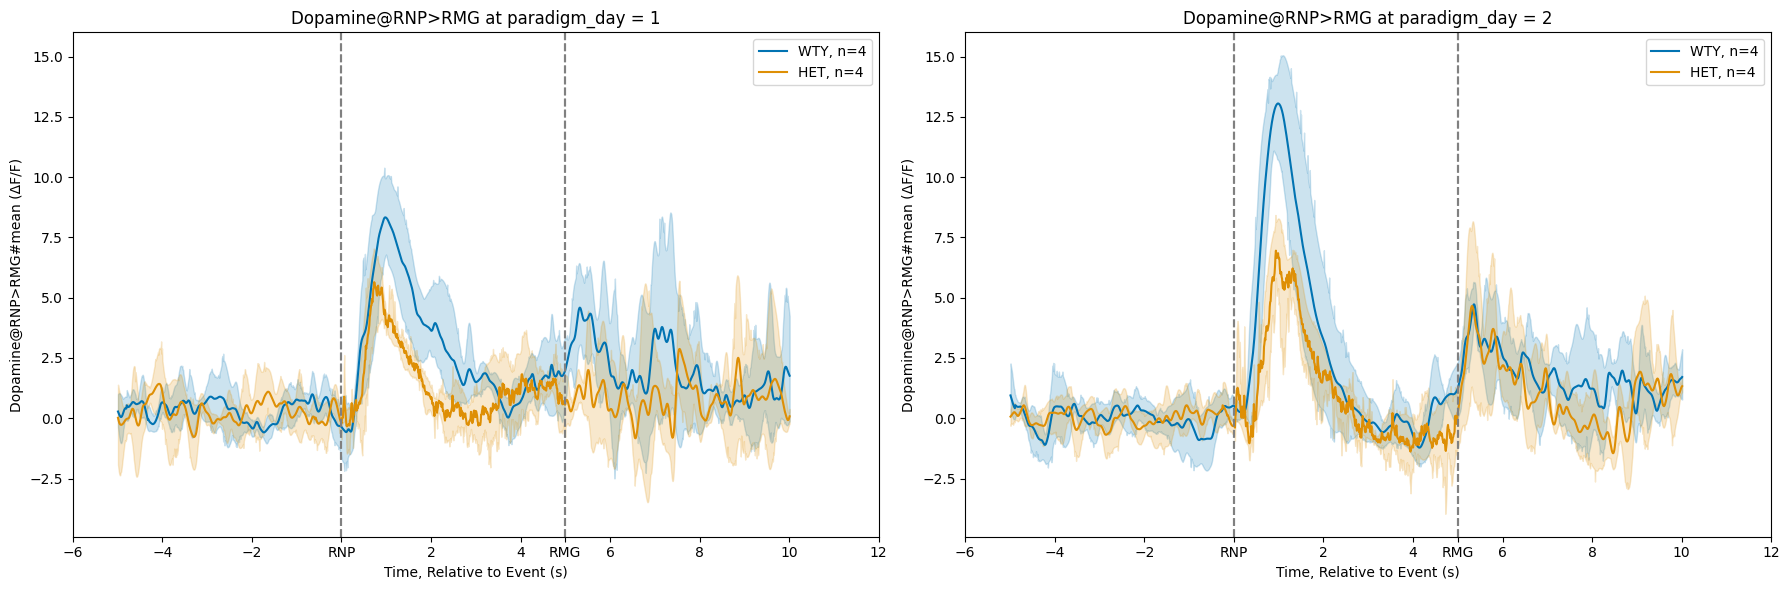

In [11]:
sig_catplot(sessions, 'Dopamine@RNP', col='paradigm_day', hue='genotype', hue_order=['WTY', 'HET'])
sig_catplot(sessions, 'Dopamine@RNP>RMG', col='paradigm_day', hue='genotype', hue_order=['WTY', 'HET'])